In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lsst.rsp import get_tap_service
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
)
from sklearn.ensemble import IsolationForest

In [2]:
service = get_tap_service("tap")
assert service is not None

filter_names = ["u", "g", "r", "i", "z", "y"]
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

In [3]:
query = """
SELECT
    diaObjectId,
    ra,
    dec,
    r_psfFluxMean,
    r_psfFluxSigma,
    r_psfFluxNdata,
    r_psfFluxLinearSlope
FROM
    dp1.DiaObject
WHERE
    r_psfFluxNdata > 5
    AND r_scienceFluxMean < 100000
"""

job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
if job.phase == "ERROR":
    job.raise_if_error()

assert job.phase == "COMPLETED"
dia_objects = job.fetch_result().to_table()

print(f"Retrieved {len(dia_objects)} DiaObjects.")

Retrieved 16704 DiaObjects.


In [4]:
sample = (
    dia_objects[
        [
            "r_psfFluxMean",
            "r_psfFluxLinearSlope",
            "r_psfFluxSigma",
        ]
    ]
    .to_pandas()
    .values
)

In [5]:
rng = np.random.RandomState(42)
ifo = IsolationForest(max_samples=500, random_state=rng, n_jobs=1)
ifo.fit(sample)

,n_estimators,100
,max_samples,500
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,1
,random_state,RandomState(M...0x796F7D227740
,verbose,0
,warm_start,False


In [6]:
scores = ifo.score_samples(sample)
outlier_indices = np.argsort(scores)[:20]

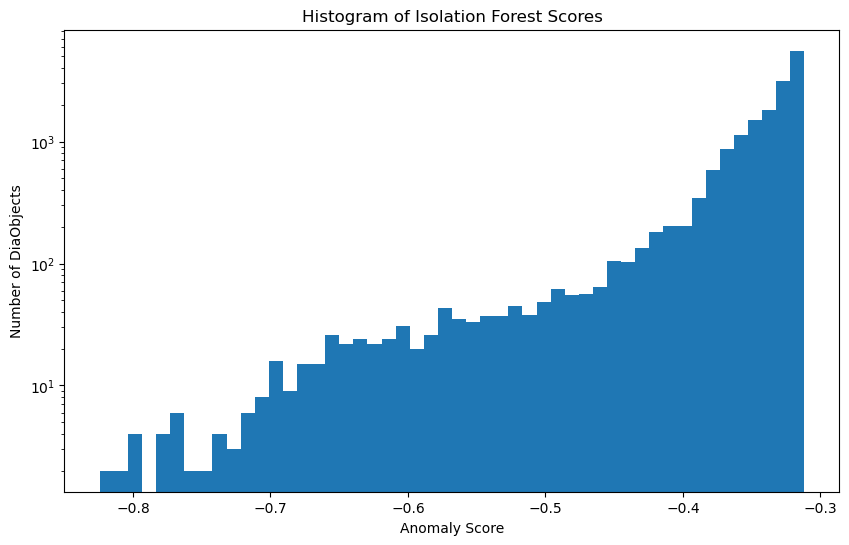

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Isolation Forest Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [8]:
outlier_diaobject_ids = dia_objects["diaObjectId"][outlier_indices]

In [9]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table()

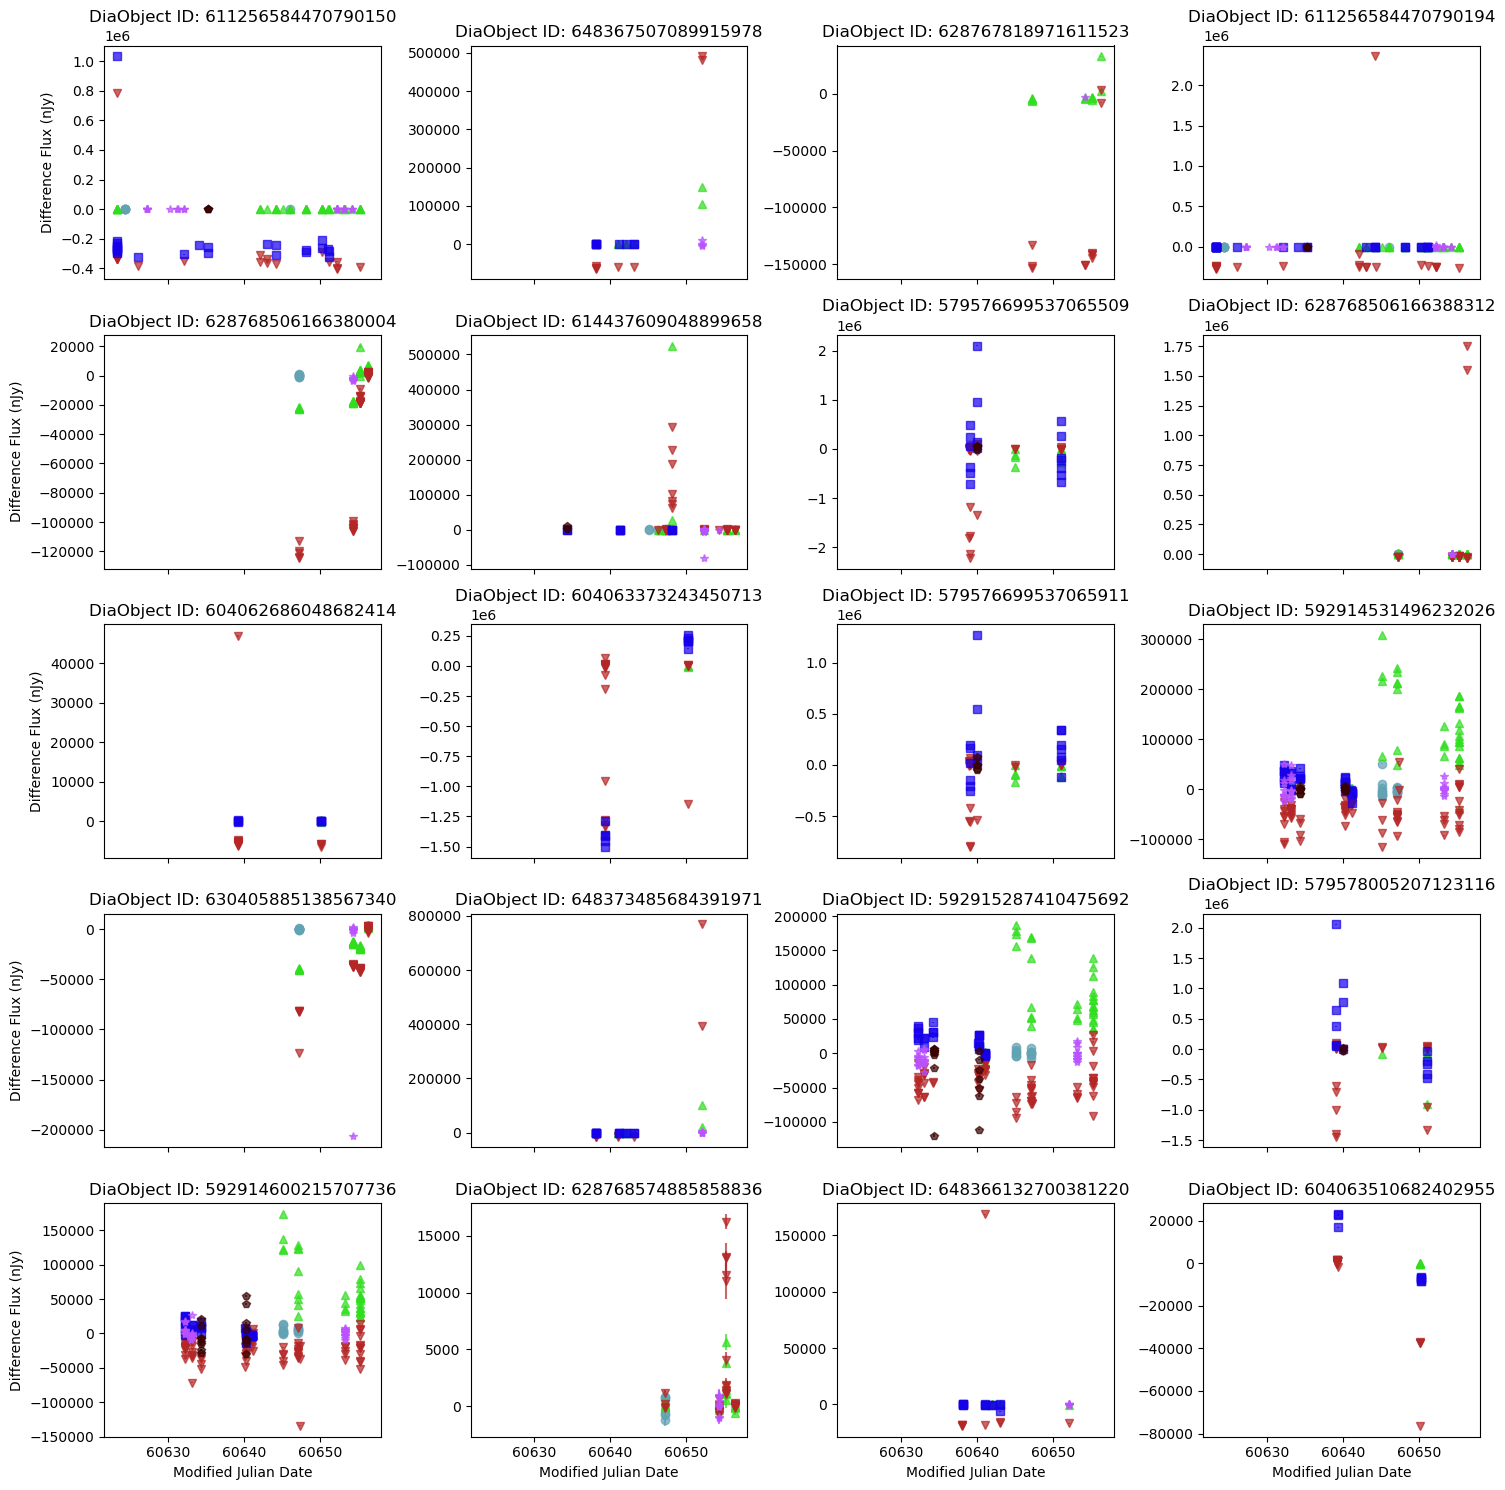

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

In [15]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects[dia_objects["diaObjectId"] == top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data['diaObjectId'][0]}")
print(f"  RA: {top_outlier_data['ra'][0]}")
print(f"  Dec: {top_outlier_data['dec'][0]}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean'][0]}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma'][0]}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope'][0]}")

Top Outlier
  DiaObject ID: 611256584470790150
  RA: 52.845969487718016
  Dec: -27.657872798692814
  r-band PSF Flux Mean: -315937.28125
  r-band PSF Flux Sigma: 177420.28303842826
  r-band PSF Flux Linear Slope: -4056.9175033357456
